# Applied Data Science Capstone

# LAPD Crime Dataset

The crime data for the areas administered by the Los Angeles Police Department was obtained from the [Los Angeles Open Data catalog](https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/y8tr-7khq). The dataset contains crime data dating back from 2010 to January 2019. This data is transcribed from original crime reports.

The format of the dataset is shown below. The full dataset contained approximately 1.9 million rows. To keep computing costs relatively low, only the crimes from 2018 were chosen. This reduced the working dataset to approximtely 225000 rows.

While I was initially successful at accessing the records through the Socrata API, it made much more sense to download the data locally, especially given the huge size of the dataset.

| Column Name | Description | Type |
|-------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------|
| DR Number | Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits | Plain Text |
| Date Reported | MM/DD/YYYY | Date & Time |
| Date Occurred | MM/DD/YYYY | Date & Time |
| Time Occurred | In 24 hour military time | Plain Text |
| Area ID | The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21 | Plain Text |
| Area Name | The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for | Plain Text |
| Reporting District | A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons | Plain Text |
| Crime Code | Indicates the crime committed (Same as Crime Code 1) | Plain Text |
| Crime Code Description | Defines the Crime Code provided | Plain Text |
| MO Codes | Modus Operandi: Activities associated with the suspect in commission of the crime | Plain Text |
| Victim Age | Two character numeric | Plain Text |
| Victim Sex | F - Female M - Male X - Unknown | Plain Text |
| Victim Descent | Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian | Plain Text |
| Premise Code | The type of structure, vehicle, or location where the crime took place | Plain Text |
| Premise Description | Defines the Premise Code provided | Plain Text |
| Weapon Used Code | The type of weapon used in the crime | Plain Text |
| Weapon Used Description | Defines the Weapon Used Code provided | Plain Text |
| Status Code | Status of the case (IC is the default) | Plain Text |
| Status Description | Defines the Status Code provided | Plain Text |
| Crime Code 1 | Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious | Plain Text |
| Crime Code 2 | May contain a code for an additional crime, less serious than Crime Code 1 | Plain Text |
| Crime Code 3 | May contain a code for an additional crime, less serious than Crime Code 1 | Plain Text |
| Crime Code 4 | May contain a code for an additional crime, less serious than Crime Code 1 | Plain Text |
| Address | Street address of crime incident rounded to the nearest hundred block to maintain anonymity | Plain Text |
| Cross Street | Cross Street of rounded Address | Plain Text |
| Location | The location where the crime incident occurred. Actual address is omitted for confidentiality. XY coordinates reflect the nearest 100 block | Location |

### Import supporting libraries

In [1]:
%matplotlib inline

import datetime
import folium
import geocoder
import geojson
import json
import re
import requests
import urllib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
import pandas as pd

from bokeh.io import show
from bokeh.models import HoverTool
from bokeh.plotting import figure, output_file, save
from bs4 import BeautifulSoup
from folium import plugins
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from haversine import haversine
from pandas.io.json import json_normalize
from scipy.spatial.distance import euclidean , cityblock
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.rcParams['axes.grid'] = True

## LAPD Precinct Data

The LAPD administers 21 Geographic Areas within the department. The location of each precinct, the division or area name and the location of each Community Police Station was obtained from the [Los Angeles Open Data catalog](http://data-lahub.opendata.arcgis.com/datasets/031d488e158144d0b3aecaa9c888b7b3_0). The JSON object was parsed to extract the relevant information.

To speed up processing, the data was stored locally on the machine after it was formatted as desired.

In [2]:
def get_lat_lng_coords(row):
    lat_lng_coords = None
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Los Angeles, CA'.format(row.location))
        lat_lng_coords = g.json['raw']['feature']['geometry']

    latitude = lat_lng_coords['y']
    longitude = lat_lng_coords['x']
    
    return pd.Series([latitude, longitude])

In [3]:
lapd_precinct_url = 'https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LAPD_Police_Stations/FeatureServer/0/query?where=1%3D1&outFields=DIVISION,LOCATION,PREC&returnGeometry=false&outSR=4326&f=json'
with urllib.request.urlopen(lapd_precinct_url) as url:
    lapd_precinct_content = json.loads(url.read().decode())

lapd_precinct_data = pd.DataFrame(columns=['precinct', 'division', 'location'])
    
for row in lapd_precinct_content['features']:
    lapd_precinct_data = lapd_precinct_data.append({
        'precinct': row['attributes']['PREC'],
        'division': row['attributes']['DIVISION'],
        'location': row['attributes']['LOCATION']
    }, ignore_index=True)
    
lapd_precinct_data.sort_values(by='precinct', inplace=True)
lapd_precinct_data = lapd_precinct_data.reset_index(drop=True)
lapd_precinct_data[['latitude', 'longitude']] = lapd_precinct_data.apply(get_lat_lng_coords, axis=1)

lapd_precinct_data.to_csv('generated_data/lapd_precinct_data.csv', index=False)

In [4]:
lapd_precinct_data = pd.read_csv('generated_data/lapd_precinct_data.csv')
lapd_precinct_data.head()

,precinct,division,location,latitude,longitude
0,1,CENTRAL,251 E. 6TH ST.,34.043882,-118.247710
1,2,RAMPART,1401 W. 6TH ST.,34.056330,-118.267360
2,3,SOUTHWEST,1546 MARTIN LUTHER KING JR. BLVD.,34.010815,-118.304883
3,4,HOLLENBECK,2111 E. 1ST ST.,34.044700,-118.213150
4,5,HARBOR,2175 JOHN S. GIBSON BLVD.,33.757466,-118.288874


## Cleaning the LAPD Crime Dataset

First, only the pertinent columns from the dataset were read into a dataframe. These columns were:
- DR Number
- Date Occurred
- Time Occurred
- Area ID
- Area Name
- Crime Code Description
- Location

In [5]:
crime_data_cols = ['DR Number', 'Date Occurred', 'Time Occurred', 'Area ID', 'Area Name', 'Crime Code Description', 'Location ']
lapd_crime_data_raw = pd.read_csv('input_data/Crime_Data_from_2010_to_Present.csv', usecols=crime_data_cols)
lapd_crime_data_raw.head()

The next step was to clean the data. This involved:
- Removing whitespace from column names
- Converting column names into lower case
- Splitting location data into latitude and longitude
- Dropping rows that contained NaN
- Typecasting columns
- Extracting additional information from Time and Date Occurred such as hour, minute, day of the week, date, month
- Finally, extracting only the crime records corresponding to the year 2018

Again, to speed up processing, the cleaned dataframe was stored locally on the machine.


In [6]:
lapd_crime_data = lapd_crime_data_raw
lapd_crime_data.columns = lapd_crime_data.columns.str.strip()
lapd_crime_data.columns = lapd_crime_data.columns.str.replace('\s{2,}', ' ')
lapd_crime_data.columns = lapd_crime_data.columns.str.replace(' ', '_')
lapd_crime_data.columns = lapd_crime_data.columns.str.lower()
lapd_crime_data['location'] = lapd_crime_data['location'].str.lstrip('\(').str.rstrip('\)')
lapd_crime_data['latitude'], lapd_crime_data['longitude'] = lapd_crime_data['location'].str.split(',', 1).str
lapd_crime_data = lapd_crime_data.drop('location', axis=1)
lapd_crime_data.dropna(inplace=True)
lapd_crime_data = lapd_crime_data.reset_index(drop=True)
lapd_crime_data['latitude'] = lapd_crime_data['latitude'].astype(float)
lapd_crime_data['longitude'] = lapd_crime_data['longitude'].astype(float)
lapd_crime_data['date_occurred'] = pd.to_datetime(lapd_crime_data['date_occurred'], format='%m/%d/%Y')
lapd_crime_data['date'] = lapd_crime_data['date_occurred'].dt.strftime('%d')
lapd_crime_data['day'] = lapd_crime_data['date_occurred'].dt.dayofweek + 1
lapd_crime_data['day_'] = lapd_crime_data['date_occurred'].dt.strftime('%A')
lapd_crime_data['month'] = lapd_crime_data['date_occurred'].dt.month
lapd_crime_data['month_'] = lapd_crime_data['date_occurred'].dt.strftime('%B')
lapd_crime_data['year'] = lapd_crime_data['date_occurred'].dt.year
lapd_crime_data['year_'] = lapd_crime_data['date_occurred'].dt.to_period('M')
lapd_crime_data['hour'] = lapd_crime_data['time_occurred'] // 100
lapd_crime_data['min'] = lapd_crime_data['time_occurred'] % 100
lapd_crime_data['time_occurred'] = lapd_crime_data['time_occurred'].astype(str)
lapd_crime_data['time_occurred'] = lapd_crime_data['time_occurred'].apply(lambda x: x.zfill(4))
lapd_crime_data = lapd_crime_data.assign(newtime=pd.to_datetime(lapd_crime_data.time_occurred, format='%H%M').dt.time)
lapd_crime_data = lapd_crime_data.drop('time_occurred', axis=1)
lapd_crime_data.rename(columns={'newtime': 'time_occurred'}, inplace=True)
lapd_crime_data_2018 = lapd_crime_data.loc[lapd_crime_data.year == 2018]
lapd_crime_data_2018 = lapd_crime_data_2018.reset_index(drop=True)

The precinct and crime dataframes were merged on the Area ID column to get a combined dataframe which was stored locally on the machine.

In [7]:
merged_data_cols = ['dr_number', 'crime_code_description', 'date_occurred', 'time_occurred', 'area_name', 'area_id', 'year', 'year_', 'month', 'month_', 'date', 'day', 'day_', 'hour', 'min', 'latitude_crime', 'longitude_crime']
lapd_crime_data_2018_merged = pd.merge(lapd_crime_data_2018, lapd_precinct_data, left_on='area_id', right_on='precinct', how='left', suffixes=('_crime', '_precinct')) 
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[merged_data_cols]
lapd_crime_data_2018_merged['time_occurred'] = pd.to_datetime(lapd_crime_data_2018_merged['time_occurred'], format='%H:%M:%S').dt.round('H').dt.time

lapd_crime_data_2018_merged.to_csv('generated_data/lapd_crime_data_2018_merged.csv', index=False)

In [8]:
lapd_crime_data_2018_merged = pd.read_csv('generated_data/lapd_crime_data_2018_merged.csv')
lapd_crime_data_2018_merged.head()

,dr_number,crime_code_description,date_occurred,time_occurred,area_name,area_id,year,year_,month,month_,date,day,day_,hour,min,latitude_crime,longitude_crime
0,180210061,THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER),2018-04-18,08:00:00,Rampart,2,2018,2018-04,4,April,18,3,Wednesday,8,30,34.0565,-118.2768
1,180210062,THEFT PLAIN - PETTY ($950 & UNDER),2018-04-17,11:00:00,Rampart,2,2018,2018-04,4,April,17,2,Tuesday,11,0,34.0570,-118.2691
2,180210065,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),2018-04-16,10:00:00,Rampart,2,2018,2018-04,4,April,16,1,Monday,10,30,34.0554,-118.2702
3,180210067,ROBBERY,2018-04-18,08:00:00,Rampart,2,2018,2018-04,4,April,18,3,Wednesday,8,0,34.0453,-118.2738
4,180210068,VEHICLE - STOLEN,2018-04-14,17:00:00,Rampart,2,2018,2018-04,4,April,14,6,Saturday,17,0,34.0663,-118.2789


In [9]:
lapd_crime_data_2018_merged.shape

(224627, 17)

A little more cleanup of the date-time information

In [10]:
lapd_crime_data_2018_merged['dt'] = pd.to_datetime(lapd_crime_data_2018_merged['date_occurred'] + ' ' + lapd_crime_data_2018_merged['time_occurred'])
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged.sort_values(['dt'], ascending=True).reset_index(drop=True)
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged.latitude_crime != 0]
lapd_crime_data_2018_merged = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged.longitude_crime != 0]

## Visualization

We can now visualize the crimes that were committed in 2018 based on various parameters such as number of crimes per:
- Type of crime
- Per month
- Per day of the week
- Per day of the month
- Per time of day
- Per area (name)

### Number of crimes per Crime Code Description
The top 25 crimes from 2018 were plotted on a bar chart. It was not very surprising to see there were a lot of theft and assault related crimes. The large number of Identity Theft cases was a surprise - perhaps we can thank Equifax for that?

Text(0.5, 1.0, 'Number of crimes per crime code description (Top 25 Crimes)')

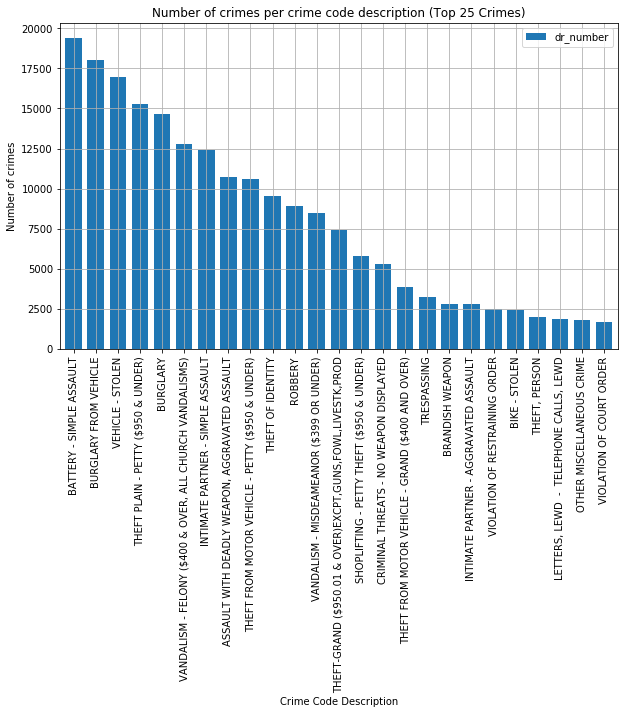

In [11]:
lapd_crime_data_2018_merged_case = lapd_crime_data_2018_merged.groupby('crime_code_description').count().sort_values(['dr_number'], ascending=False)
lapd_crime_data_2018_merged_case.head(25)
lapd_crime_data_2018_merged_case[:25].plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Crime Code Description')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per crime code description (Top 25 Crimes)')

### Number of crimes per Month
The crimes from 2018 were plotted on a bar chart as number of crimes per month. The number of crimes stayed consistent with a dip in February, which can be attributed to a lower number of days in the month and an increase in the summer months.

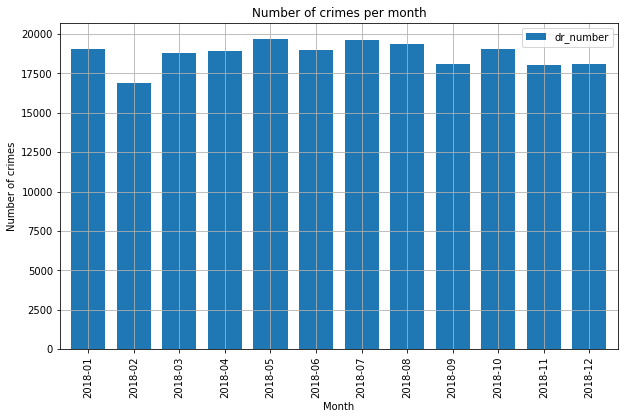

In [12]:
lapd_crime_data_2018_merged_month = lapd_crime_data_2018_merged.groupby('year_').count()
lapd_crime_data_2018_merged_month.head(25)
lapd_crime_data_2018_merged_month.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Month')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per month');

### Number of crimes per Day of the Week
The crimes from 2018 were plotted on a bar chart as number of crimes per day of the week. The number of crimes stayed consistent with a slight increase on Fridays (day 5).

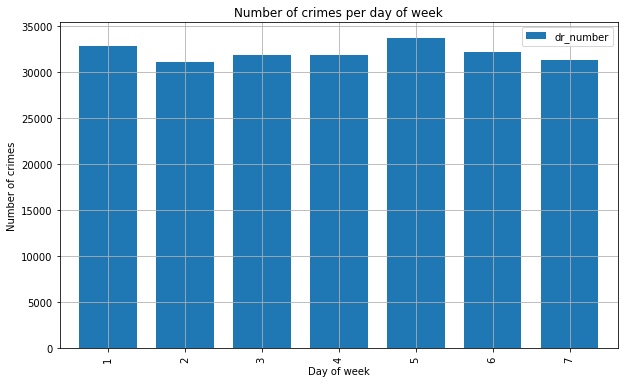

In [13]:
lapd_crime_data_2018_merged_day = lapd_crime_data_2018_merged.groupby('day').count()
lapd_crime_data_2018_merged_day.head(25)
lapd_crime_data_2018_merged_day.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Day of week')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per day of week');

### Number of crimes per Day of the Month
The crimes from 2018 were plotted on a bar chart as number of crimes per day of the month. The number of crimes stayed consistent throughout the month typically. The drop in number of crimes on the 31st is because not every month has 31 days. Similarly with reduced contributions from February (29th and 30th). It could potentially be an issue and the data would likely need a weighted average of some kind to scale it uniformly. 

The spike in crimes on the 1st day of the month is surprising. It could perhaps be attributed to pay days and the need for money to cover bills. Also, a careful look at the data revealed a significant percentage of the crimes on the 1st was on 1/1. NYE sees a lot of revellers out late and it could be a big driver in crimes on that date.

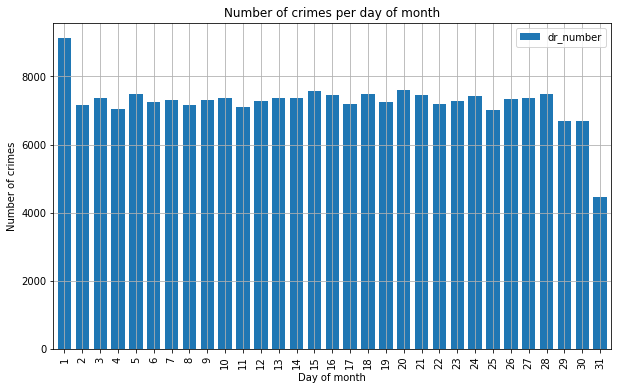

In [14]:
lapd_crime_data_2018_merged_date = lapd_crime_data_2018_merged.groupby('date').count()
lapd_crime_data_2018_merged_date.head(25)
lapd_crime_data_2018_merged_date.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Day of month')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per day of month');

### Number of crimes per Time of Day
The crimes from 2018 were plotted on a bar chart as number of crimes per time of day. The drop after midnight is not surprising. The spike at noon is though while the spikes later in the evening are as expected.

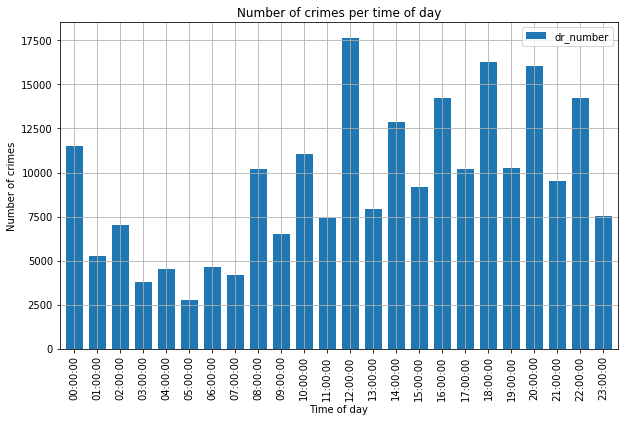

In [15]:
lapd_crime_data_2018_merged_time = lapd_crime_data_2018_merged.groupby('time_occurred').count()
lapd_crime_data_2018_merged_time.head(25)
lapd_crime_data_2018_merged_time.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Time of day')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per time of day');

### Number of crimes per Area
The crimes from 2018 were plotted on a bar chart as number of crimes per area of occurrence. It is clear which areas are the most dangerous - 77th Street, Central and Southwest are not the best neighborhoods in the city either. 

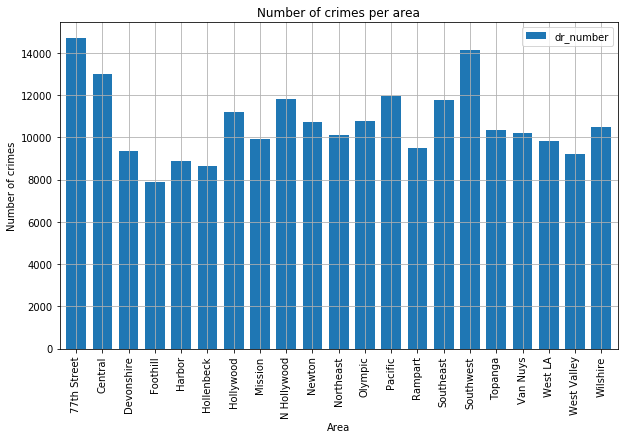

In [16]:
lapd_crime_data_2018_merged_area = lapd_crime_data_2018_merged.groupby('area_name').count()
lapd_crime_data_2018_merged_area.head(25)
lapd_crime_data_2018_merged_area.plot(y='dr_number', kind='bar', figsize=(10,6), width=0.75, )
plt.xlabel('Area')
plt.ylabel('Number of crimes')
plt.title('Number of crimes per area');

## More Cool Visualizations
The next section has some cool visualiztions that show the crime distributions in the city using choropleths, heat maps and cluster maps.

In [17]:
address = 'Los Angeles, CA'
geolocator = Nominatim(user_agent='explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

The top 5 crimes by count were selected from the 2018 crime dataframe. These were assigned a color and the result was charted using folium.

In [18]:
lapd_crime_2018_top5 = lapd_crime_data_2018_merged_case.head(5).index.tolist()
lapd_crime_data_2018_top5 = lapd_crime_data_2018_merged[lapd_crime_data_2018_merged['crime_code_description'].isin(lapd_crime_2018_top5)].reset_index(drop=True)

colors = ['red', 'blue', 'green', 'orange', 'purple'] 
colordict = dict(zip(lapd_crime_2018_top5, colors))
lapd_crime_data_2018_top5['color'] = lapd_crime_data_2018_top5['crime_code_description'].apply(lambda x: colordict[x])

In [19]:
la_map = folium.Map(location=[latitude, longitude], zoom_start=11)
la_map

incidents = folium.map.FeatureGroup()
for _, row in lapd_crime_data_2018_top5.iterrows():
    popup_text = '{} <br> Date: {} <br> Time: {}'.format(row.crime_code_description, row.date_occurred, row.time_occurred)
    
    incidents.add_child(
        folium.features.CircleMarker(
            [row.latitude_crime, row.longitude_crime],
            radius = 2.5,
            color = row.color,
            popup = popup_text,
            fill = True,
            fill_color = col,
            fill_opacity = 0.6,
            prefer_canvas = True
        )
    )

# add incidents to map
la_map.add_child(incidents)
la_map.save('html_maps/la_map.html')

![](images/1_la_map.png)

In [20]:
la_cluster_map = folium.Map(location = [latitude, longitude], zoom_start = 12)

incidents = plugins.MarkerCluster().add_to(la_cluster_map)

for lat, lng, label, in zip(lapd_crime_data_2018_top5.latitude_crime, lapd_crime_data_2018_top5.longitude_crime, lapd_crime_data_2018_top5.crime_code_description):
    folium.Marker(
        location = [lat, lng],
        icon = None,
        popup = label,
    ).add_to(incidents)

la_cluster_map.save('html_maps/la_cluster_map.html')

![](images/2_la_cluster_map.png)

In [21]:
la_choropleth_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

lapd_json = r'input_data/lapd-divisions.geojson'

df_agg = lapd_crime_data_2018_merged.groupby(by='area_name').size().reset_index(name='count')

threshold_scale = np.linspace(df_agg['count'].min(), df_agg['count'].max(), 6, dtype=int)
threshold_scale = threshold_scale.tolist()
threshold_scale[-1] += 1

la_choropleth_map.choropleth(
    legend_name = 'Crime Rate in Los Angeles',
    threshold_scale=threshold_scale,
    geo_data = lapd_json,
    data = df_agg,
    columns = ['area_name', 'count'],
    key_on = 'feature.properties.name',
    fill_color = 'YlOrRd',
    fill_opacity = 0.7,
    line_opacity = 0.2,
)

la_choropleth_map.save('html_maps/la_choropleth_map.html')

![](images/3_la_choropleth_map.png)

In [22]:
la_heat_map = folium.Map(location = [latitude, longitude], zoom_start = 10)

map_data = [[row.latitude_crime, row.longitude_crime] for _, row in lapd_crime_data_2018_merged.iterrows()]

plugins.HeatMap(map_data,
        min_opacity = 0.5,
        max_zoom = 18, 
        max_val = 1.0, 
        radius = 12.5,
        blur = 25,
        gradient = None,
        overlay = True).add_to(la_heat_map)

la_heat_map.save('html_maps/la_heat_map.html')

![](images/4_la_heat_map.png)

I also generated some dynamic marker and heat maps to visualize the top 5 crimes over time

In [23]:
def create_geojson_features(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['longitude_crime'],row['latitude_crime']]
            },
            'properties': {
                'time': row['dt'].date().__str__(),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    'fillColor': row['color'],
                    'fillOpacity': 0.8,
                    'stroke': 'true',
                    'radius': 7
                }
            }
        }
        features.append(feature)
    return features

def make_map(features):
    coords = [latitude, longitude]
    la_map_dynamic = folium.Map(location=coords, control_scale=True, zoom_start=8)

    plugins.TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}, 
        period='P1M',
        add_last_point=True,
        auto_play=False,
        loop=False
    ).add_to(la_map_dynamic)
    return la_map_dynamic

features = create_geojson_features(lapd_crime_data_2018_top5)
feature_collection = geojson.FeatureCollection(features)

with open('generated_data/myfile.geojson', 'w') as f:
   geojson.dump(feature_collection, f)

la_map_dynamic = make_map(features)
la_map_dynamic.save('html_maps/la_map_dynamic.html')

In [24]:
heat_df = lapd_crime_data_2018_merged.copy()
heat_df = heat_df[['latitude_crime', 'longitude_crime', 'month', 'date_occurred']]
heat_df['Weight'] = heat_df['month']
heat_df['Weight'] = heat_df['Weight'].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['latitude_crime','longitude_crime', 'Weight'])

heat_data = [[[row['latitude_crime'],row['longitude_crime'],row['Weight']] 
                for index, row in heat_df[heat_df['Weight'] == i].iterrows()] 
                 for i in range(1,13)]

la_heat_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
idx = lapd_crime_data_2018_merged.year_.unique().tolist()
hm = plugins.HeatMapWithTime(heat_data, index=idx)
hm.add_to(la_heat_map)

# Display the map
la_heat_map.save('html_maps/la_heat_map_monthly_dynamic.html')

Another cool line chart visualizing the top 5 crimes over the year

In [25]:
lapd_crime_data_2018_crime_by_date = lapd_crime_data_2018_merged['dt'].dt.date.value_counts().sort_index()

plot = figure(x_axis_type='datetime', tools='',
              toolbar_location=None, x_axis_label='Dates',
            y_axis_label='Crime count', title='Hover over line to see crime counts', width=1800)

plot.line(lapd_crime_data_2018_crime_by_date.index, lapd_crime_data_2018_crime_by_date.values, 
          line_dash='4 4', line_width=1, color='red')

cr = plot.circle(lapd_crime_data_2018_crime_by_date.index, lapd_crime_data_2018_crime_by_date.values, size=10,
                fill_color='gold', hover_fill_color='black',
                fill_alpha=0.05, hover_alpha=0.5,
                line_color=None, hover_line_color='black')
plot.left[0].formatter.use_scientific = False

plot.add_tools(HoverTool(tooltips=None, renderers=[cr], mode='hline'))

show(plot)
# output_file('html_maps/la_crime_by_date.html')
# save(plot)

![](images/5_la_crime_by_date.png)

## Data Modeling
The 2018 crime data frame was modeled using a Random Forest algorithm. The classification of crimes was based on location, time and date.

- The first step was to classify dangerous crimes such as assault and theft related crimes and assign them a value 1. All other crimes were classified with a 0.
- The next step was applying One-Hot Encoding on the hour of day, day of month, month, latitude and longitude where the crime occurred.

In [26]:
dangerous_crimes = ['BATTERY - SIMPLE ASSAULT',
 'BURGLARY FROM VEHICLE',
 'VEHICLE - STOLEN',
 'THEFT PLAIN - PETTY ($950 & UNDER)',
 'BURGLARY',
 'ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT',
 'THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)',
 'CRIMINAL THREATS - NO WEAPON DISPLAYED',
 'THEFT FROM MOTOR VEHICLE - GRAND ($400 AND OVER)',
 'BRANDISH WEAPON',
 'BATTERY WITH SEXUAL CONTACT',
 'RAPE, FORCIBLE',
 'OTHER ASSAULT',
 'DISCHARGE FIREARMS/SHOTS FIRED',
 'VEHICLE - ATTEMPT STOLEN',
 'CRIMINAL HOMICIDE',
 'BURGLARY FROM VEHICLE, ATTEMPTED',
 'PICKPOCKET',
 'KIDNAPPING',
 'THEFT FROM MOTOR VEHICLE - ATTEMPT',
 'PURSE SNATCHING',
 'RAPE, ATTEMPTED',
 'THEFT FROM PERSON - ATTEMPT',
 'SHOTS FIRED AT MOVING VEHICLE, TRAIN OR AIRCRAFT',
 'PURSE SNATCHING - ATTEMPT',
 'PICKPOCKET, ATTEMPT']

In [27]:
# features = lapd_crime_data_2018_merged[['crime_code_description', 'latitude_crime', 'longitude_crime']]
# features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.hour, prefix='hour'))
# features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.day_))
# features = features.join(pd.get_dummies(lapd_crime_data_2018_merged.month_))
# features['dangerous_crime'] = 0

# features.loc[features.crime_code_description.isin(dangerous_crimes), 'dangerous_crime'] = 1

# features.to_csv('generated_data/features.csv', index=False)
# features.head()

,crime_code_description,latitude_crime,longitude_crime,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,April,August,December,February,January,July,June,March,May,November,October,September,dangerous_crime
0,VEHICLE - STOLEN,34.1329,-118.2084,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,THEFT OF IDENTITY,34.2596,-118.4640,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,VEHICLE - STOLEN,34.0181,-118.4213,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,BATTERY - SIMPLE ASSAULT,34.0790,-118.3004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,BATTERY - SIMPLE ASSAULT,34.0790,-118.3004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


## Random Forest Algorithm
The RF algorithm was chosen to model and classify the dataset. This algorithm searches for the best feature among a random subset of features while splitting a node. Another important advantage of this algorithm is the ability to visualize the relative importance of different features.

The dataset was split into train and test datasets.

In [28]:
# X = features.drop(['dangerous_crime', 'crime_code_description'], axis=1)
# # X = preprocessing.StandardScaler().fit(X).transform(X)
# y = features.dangerous_crime.values

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

The hyperparameter *n_estimators* was tuned over a range of values. The accuracy looked to be topping out at *n = 100*. The other hyperparameters were left to be at their default values.

In [29]:
# N = [5, 10, 20, 40, 100, 200, 500]
# scores = []
# f1 = []
# jaccard = []

# for n in N:
#     rf_model = RandomForestClassifier(n_estimators=n, max_features='auto').fit(X_train, y_train)
#     yhat_rf = rf_model.predict(X_test)

#     rf_score = rf_model.score(X_test, y_test)
#     rf_f1 = metrics.f1_score(y_test, yhat_rf, average='weighted')
#     rf_jaccard = metrics.jaccard_similarity_score(y_test, yhat_rf)

#     scores.append(rf_score)
#     f1.append(rf_f1)
#     jaccard.append(rf_jaccard)

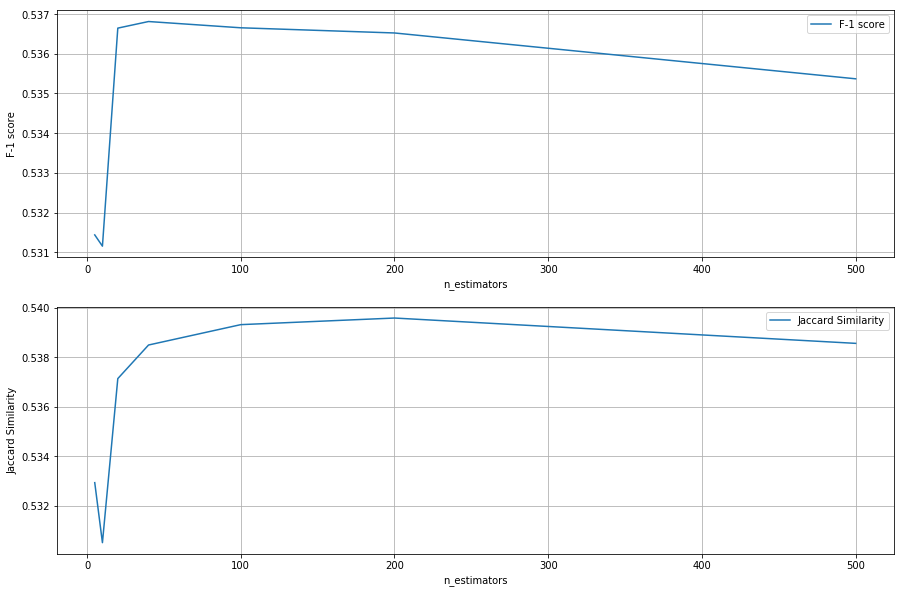

In [30]:
# fig, ax = plt.subplots(2, 1, sharex=True)
# fig.set_size_inches(15,10)

# plt.subplot(2, 1, 1)
# ax[0] = plt.plot(N, f1, label='F-1 score')
# plt.xlabel('n_estimators')
# plt.ylabel('F-1 score')
# plt.legend()

# plt.subplot(2, 1, 2)
# ax[1] = plt.plot(N, jaccard, label='Jaccard Similarity')
# plt.xlabel('n_estimators')
# plt.ylabel('Jaccard Similarity')
# plt.legend()

# plt.show()

The RF model was created with *n_estimators = 100*. The important features were visualized and as expected, it is the location (latitude & longitude) feature which dominates over any other feature. 

In [31]:
n_best = 100

rf_model = RandomForestClassifier(n_estimators=n_best, max_features='auto').fit(X_train, y_train)
yhat_rf = rf_model.predict(X_test)

In [32]:
rf_score = rf_model.score(X_test, y_test)
rf_f1 = metrics.f1_score(y_test, yhat_rf, average='weighted')
rf_jaccard = metrics.jaccard_similarity_score(y_test, yhat_rf)
rf_logloss = metrics.log_loss(y_test, yhat_rf)

print('F-1 score: {}'.format(rf_f1))
print('Jaccard Similarity: {}'.format(rf_jaccard))

F-1 score: 0.5364049047122339
Jaccard Similarity: 0.5388536449638286


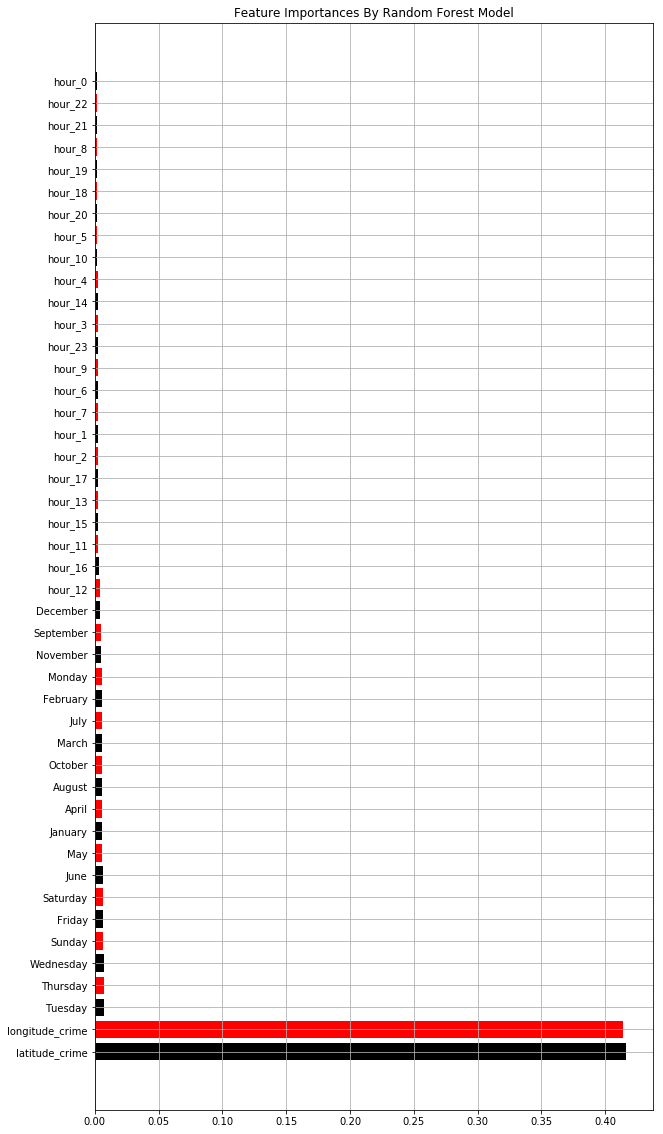

In [33]:
importances = rf_model.feature_importances_

std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

sorted_important_features = []
for i in indices:
    sorted_important_features.append(X_test.columns[i]) 

plt.figure(figsize=(10,20))
plt.title('Feature Importances By Random Forest Model')
plt.barh(range(len(indices)), importances[indices], color=['black','red'], yerr=std[indices], align='center')
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

# Neighborhood and Venue Data

## Neighborhoods administered by the LAPD

The data for venues and businesses around a geographic location was obtained through the Foursquare API. The first step was to identify the neighborhoods for which crime data was available. This was necessary because the LAPD does not ohave jurisdiction over several areas in LA County and these are administered through their own police departments for which crime data was not available. 

The data for the neighborhoods served by the LAPD was scraped from the [LA Times website](http://maps.latimes.com/lapd/). The JSON object for each divison was inspected and the neighborhood information was extracted. Additionally, the latitude and longitude for each neighborhood was retrieved using the geocoder class. This dataframe was stored locally on the machine.

In [34]:
lapd_city_url_head = 'http://maps.latimes.com/lapd/division/'
lapd_precinct_data['city_url'] = lapd_city_url_head + lapd_precinct_data['division'].str.replace(' ', '-').str.lower()

la_city_data = {}

for _, row in lapd_precinct_data.iterrows():
    cities = []
    content = requests.get(row.city_url).text
    soup = BeautifulSoup(content, 'lxml')
    for a in soup.find_all('a', href=re.compile(r'/neighborhoods/neighborhood/(.*)/crime')):
        if a.text:
            cities.append(a.text.replace('Unincorporated', '').strip(' \t \n \r'))
            ,
    la_city_data[row.division] = cities   

la_city_data = pd.DataFrame(dict([(k.title(), pd.Series(v)) for k,v in la_city_data.items()])).melt(var_name='division', value_name='location').dropna()
la_city_data[['latitude', 'longitude']] = la_city_data.apply(get_lat_lng_coords, axis=1)
la_city_data.rename(columns={'location': 'neighborhood'}, inplace=True)

lapd_precinct_data.drop('city_url', axis=1, inplace=True)
la_city_data.to_csv('generated_data/la_city_data.csv', index=False)

We also found there were some instances where parts of a neighborhood were administered by different divisions of the LAPD. In these instances, a simple assumption was made to assign the neighborhood to the first division it appeared under in the dataset. This can be handled more cleverly by partitioning the neighborhood but was deemed unnecessary for this analysis.

In [35]:
la_city_data = pd.read_csv('generated_data/la_city_data.csv')
la_city_data = la_city_data.drop('division', axis=1).sort_values(by='neighborhood', ascending=True).drop_duplicates(subset='neighborhood', keep='first').reset_index(drop=True)

## Foursquare Venue Data

The next step was to use the Foursquare API to retrieve data for businesses and services around a particular neighborhood. We searched for the following categories of businesses and services in a 1 mile radius, limiting our results to 50 venues under each category:
* Arts & Entertainment - Music venues, Theatres, Concert Halls, Bowling Alleys
* Fitness Center - Gyms, Yoga Studios, Pilates
* Food - Restaurants, Fast-Food Joints, Cafes
* Medical Center - Hospitals, Urgent Care Clinics, Pharmacies
* Nightlife Spot - Bars, Lounges, Nightclubs
* Shop & Service - Grocery Stores, Utilities Providers, Services

Additionally, in order to beautify our map, we assigned a representative icon and color for each business belonging to one of the above categories.

The JSON object was inspected and the following details were extracted:
* Venue Name
* Venue ID
* Venue Category
* Venue Address
* Venue Latitude & Longitude

Using the Venue ID, a subsequent call was designed to extract the venue rating. However, this is a Premium endpoint and was limited to only 500 requests per day which was not sufficient to handle our dataset of approximately 24000 venues. While the code is shown below, we subsequently discard the *venue_rating* column from our dataset. The dataframe was stored locally on the machine for faster retrieval.

In [36]:
# @hidden_cell

CLIENT_ID = '2ITIJOBIMJWSM5YZKMW5CIEC3GZVBTEPXEMKZWN30Q1ASSV3'
CLIENT_SECRET = 'C2ZVPDC1AZZWYXAM54JQEVQEYCAKZ1GZ54YYRPJMA1Q10IU2'
VERSION = '20180605'

LIMIT = 50
radius = 1600

categories = {
    'Arts & Entertainment': ('4d4b7104d754a06370d81259', 'film', 'blue'),
    'Fitness Center': ('4bf58dd8d48988d175941735', 'tower', 'gray'),
    'Food': ('4d4b7105d754a06374d81259', 'cutlery', 'purple'),
    'Medical Center': ('4bf58dd8d48988d104941735', 'heart', 'red'),
    'Nightlife Spot': ('4d4b7105d754a06376d81259', 'glass', 'darkpuple'),
    'Shop & Service': ('4d4b7105d754a06378d81259', 'shopping-cart', 'cadetblue'),
    }

In [37]:
def getNearbyVenues(names, latitudes, longitudes):
    
    columns = ['neighborhood', 'neighborhood_latitude', 'neighborhood_longitude', 'venue_name', 'venue_id', 'venue_rating', 'venue_category', 'venue_category_id', 'venue_address', 'venue_city', 'venue_latitude', 'venue_longitude', 'icon', 'color']

    def getVenueRating(venueId):
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(venueId, CLIENT_ID, CLIENT_SECRET, VERSION)
        try:    
            return requests.get(url).json()['response']['venue']['rating']
        except:
            return float('NaN')
    
    venues_list = []
    venues_df = []
    
    for neighborhood, lat, lng in zip(names, latitudes, longitudes):
        for category, category_params in categories.items():
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, category_params[0], radius, LIMIT)
            try:
                results = requests.get(url).json()['response']['venues']
#                 print('Added: {}, {}'.format(neighborhood, category))
                venue_list = [(neighborhood, lat, lng, v['name'], v['id'], getVenueRating(v['id']), v['categories'][0]['name'], category_params[0], v['location']['formattedAddress'][0], v['location']['formattedAddress'][1], v['location']['lat'], v['location']['lng'], category_params[1], category_params[2]) for v in results]
                venues_df.append(pd.DataFrame([item for item in venue_list], columns=columns))
            except:
#                 print('Skipped: {}, {}'.format(neighborhood, category))
                venues_df.append(pd.DataFrame(columns=columns))

    venues_df = pd.concat(venues_df, ignore_index=True)
    mask = ~venues_df['venue_id'].duplicated(keep='first')
    return venues_df[mask]

In [38]:
# la_city_venues = getNearbyVenues(names=la_city_data.neighborhood, latitudes=la_city_data.latitude, 
#                                  longitudes=la_city_data.longitude)
# la_city_venues.to_csv('generated_data/la_city_venues.csv', index=False)

In [39]:
la_city_venues = pd.read_csv('generated_data/la_city_venues.csv')
la_city_venues = la_city_venues.drop('venue_rating', axis=1)

In [41]:
la_city_venues.shape

(23932, 13)

## More Visualiztions!

Finally, we can superimpose our neighborhood data with the heat maps from our crime data to get an informative understanding of the safety of a neighborhood as well as its offerings. The maps were generated for 156 (yeah, LA is huge!) neighborhoods in LA. A few of them are shown here.

Please note the folium maps rendered by Jupyter do not show up on Github. This is a known issue, therefore, screenshots of the maps themselves have been included in the entire notebook.

In [40]:
# map_data = [[row.latitude_crime, row.longitude_crime] for _, row in lapd_crime_data_2018_merged.iterrows()]

#  for _, city_row in la_city_data.iterrows():
#     df = la_city_venues.loc[la_city_venues.neighborhood==city_row.neighborhood]
    
#     if df.empty is not True:
        
#         la_heat_map = folium.Map(location = [city_row.latitude, city_row.longitude], zoom_start = 14)
        
#         plugins.HeatMap(map_data,
#                 min_opacity = 0.5,
#                 max_zoom = 18, 
#                 max_val = 1.0, 
#                 radius = 20,
#                 blur = 30,
#                 gradient = None,
#                 overlay = True).add_to(la_heat_map);
        
#         folium.Marker(
#                 location=[city_row.latitude, city_row.longitude],
#                 popup='Neighborhood: {}'.format(city_row.neighborhood),
#                 icon=folium.Icon(color='black')
#             ).add_to(la_heat_map)
        

#         for _, row in df.iterrows():
#             folium.Marker(
#                 location=[row.venue_latitude, row.venue_longitude],
#                 popup='Venue: {} <br> Category: {}'.format(row.venue_name, row.venue_category),
#                 icon=folium.Icon(icon=row.icon, color=row.color)
#             ).add_to(la_heat_map)

#         la_heat_map.save('neighborhood_maps/{}_heat_map_venues.html'.format(city_row.neighborhood.lower().replace('/', '-').replace(' ', '_')))

### Downtown LA Venue + Crime Heat Map

![](images/14_downtown_heat_map_venues.png)

### Elysian Park Venue + Crime Heat Map

![](images/15_elysian_park_heat_map_venues.png)

### Hollywood Venue + Crime Heat Map

![](images/17_hollywood_heat_map_venues.png)

### Koreatown Venue + Crime Heat Map

![](images/16_koreatown_heat_map_venues.png)

### Van Nuys Venue + Crime Heat Map

![](images/18_van_nuys_heat_map_venues.png)